In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pytorch ver .  1.11.0+cu113
Is CUDA available? True


# Read data

In [4]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [5]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [6]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [7]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [8]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [9]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,6816])
Yhat_train = np.zeros([540,5112])
Xhat_val = np.zeros([61,6816])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])

for i in range (0,540):
    for j in range (0,1704):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i][j+1704] = Xhat[i][j+1704]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_val[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_val[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_val[i-540][j] = Yhat[i][j]     
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_test[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_test[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_test[i-540][j] = Yhat[i][j]
        
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(540, 6816)
Yhat_train
(540, 5112)
Xhat_val
(61, 6816)
Yhat_val
(61, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


# Modeling

In [10]:
x_train = torch.from_numpy(Xhat_train).float()
y_train = torch.from_numpy(Yhat_train).float()
x_val = torch.from_numpy(Xhat_val).float()
y_val = torch.from_numpy(Yhat_val).float()
x_test = torch.from_numpy(Xhat_test).float()
y_test = torch.from_numpy(Yhat_test).float()

In [11]:
class PytorchLightningModel(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(6816 , 5112)

    def forward(self, x): 
        ouput = self.layer1(x)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("train_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs }

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("test_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs}

    # def test_eposh_end(self, outputs):
    #     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #     logs = {'test_loss': avg_loss}      
    #     #return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    #     return {'avg_test_loss': avg_loss, 'log': logs}

    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("val_loss_MAE", loss)
        return {'loss' : loss ,  'log' : logs}
    
    # def validation_epoch_end(self, outputs): 
    #     avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     logs = {'val_loss': avg_loss}
    #     return {'avg_val_loss': avg_loss, 'log' : logs, 'progress_bar': logs}

In [ ]:
logger1 = TensorBoardLogger("jupyterNB_logs", name="NN_96hr")
logger2 = CSVLogger("jupyterNB_logs", name="NN_96hr_csv")
model = PytorchLightningModel() 
trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger2)
trainer.fit(model)
trainer.test(model)
trainer.test(model)

# Result

In [20]:
df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/NN_96hr_csv/version_0/metrics.csv")
s=np.array(df['val_loss_MAE'].fillna(np.nanmean(df['val_loss_MAE'])))
score=np.min(s)
print(score)

5.445780754089356


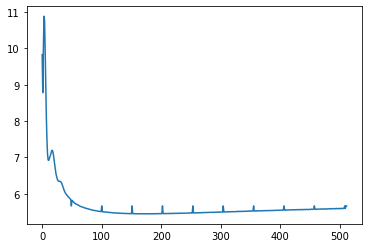

In [18]:
plt.plot(s)